In [1]:
import os as os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob as glob
from scipy import stats

### Function to import kofamscan outputs for each MAG, remove empty rows, add col with MAG name

In [3]:
#The D7 MAGS will have to be re-named to fit this scheme
x = "human_MAGs_kofams/H1.001.fasta.faa.kofam.filt"
def make_mag_ko_matrix(file):
    a = file.split('.')
    name = a[0] + '_' + a[1]
    ko = pd.read_csv(file, sep='\t', names=[])
    print(name)

make_mag_ko_matrix(x)

human_MAGs_kofams/H1_001


In [6]:
# Try to run Roth's script to convert the kofamscan results into a table.
#os.chdir('cow_MAGs_kofams/')
#%run -i 03c_KofamScan_Filter_Convert.py -i 'cow_MAGs_kofams/cow4.001.fasta.faa.kofam.filt' -o test

for file in "*MAGs_kofams/*.filt":
    a = file.split('.')
    name = a[0] + '_' + a[1]
    %run -i 01b_Parse_KEGG_Hierarchy.py -i file -o name.table

IndexError: list index out of range

### Import the KO count matrix generated from previous steps and pivot the rows and colums

In [53]:
KO_counts = pd.read_csv("KO_counts/KO_counts_table.txt", sep='\t', index_col=0)
#KO_counts.shape  => (3562, 81)

KO_counts_pivot = pd.pivot_table(KO_counts,columns="Tag")
KO_counts_pivot.tail()

Tag,K00003,K00005,K00009,K00012,K00013,K00014,K00015,K00016,K00018,K00020,...,K23876,K23886,K23975,K23976,K23977,K23989,K23997,K23999,K24012,K24042
pig9_22,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
pig9_24,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
pig9_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pig9_30,0,0,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
pig9_6,0,0,1,0,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
##drop columns whose sum is <2 (i.e. singleton KOS found in only 1 MAG)!

sum = KO_counts_pivot.sum(axis=0)
KO_lessThan2 = list()
KO_lessThan3 = list()
for col in range(len(sum)):
    if sum[col] < 2:
            KO_lessThan2.append(col)
#len(KO_lessThan2) => 757 KOs are singletons (only found in 1 MAG)
#len(KO_lessThan3) => 1098 KOs are doubletons

KO_drop_singletons = KO_counts_pivot.loc[: , (KO_counts_pivot.sum(axis=0) !=1)]
KO_drop_singletons.tail()

Tag,K00003,K00005,K00009,K00012,K00013,K00014,K00015,K00016,K00018,K00020,...,K23675,K23684,K23753,K23775,K23779,K23876,K23997,K23999,K24012,K24042
pig9_22,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
pig9_24,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
pig9_3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
pig9_30,0,0,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
pig9_6,0,0,1,0,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0


### Run t-tests on KO values

In [110]:
## Add rows (i.e. Series) to the dataframe
KO_ttest = KO_counts_pivot.append(pd.Series(name='ttest'))
KO_ttest = KO_ttest.append(pd.Series(name='p-value'))
print(KO_ttest.shape)

ttest = KO_ttest.iloc[81]
type(ttest)
pval = KO_ttest.iloc[82]

##Split the df up by host type:
h_c = KO_ttest.iloc[:31, :]
h_c = h_c.append(pd.Series(name='ttest'))
h_c = h_c.append(pd.Series(name='p-value'))

## rm the KO COLUMNS that are zero across all rows
h_c = h_c.loc[: , (h_c.sum(axis=0) !=1)]
h_c.shape


(83, 3562)


(33, 2984)

In [83]:
## Fill new rows with results for scipy t-tests
human_MAGS = KO_ttest.index.values[:13]
cow = KO_ttest.index.values[13:31]
pig = KO_ttest.index.values[31:81]

KO_ttest.iloc[81] = np.array(stats.ttest_ind(KO_ttest.iloc[:13, :], KO_ttest.iloc[13:31, :], axis=0, equal_var=False))[0]
KO_ttest.iloc[82] = np.array(stats.ttest_ind(KO_ttest.iloc[:13, :], KO_ttest.iloc[13:31, :], axis=0, equal_var=False))[1]

KO_ttest.tail()

/Users/brittanysuttner/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/brittanysuttner/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/brittanysuttner/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Tag,K00003,K00005,K00009,K00012,K00013,K00014,K00015,K00016,K00018,K00020,...,K23876,K23886,K23975,K23976,K23977,K23989,K23997,K23999,K24012,K24042
pig9_3,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
pig9_30,0.000000,0.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
pig9_6,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
ttest,2.013776,NaN,1.000000,2.411342,1.567555,2.570552,1.000000,-0.823486,0.903761,1.477098,...,NaN,1.000000,NaN,NaN,NaN,NaN,0.932173,0.225189,1.000000,0.225189
p-value,0.057113,NaN,0.337049,0.023456,0.128175,0.015925,0.337049,0.417069,0.375644,0.165407,...,NaN,0.337049,NaN,NaN,NaN,NaN,0.359260,0.823795,0.337049,0.823795


In [111]:
## Run the t-tests
h_c.iloc[31] = np.array(stats.ttest_ind(h_c.iloc[:13, :], h_c.iloc[13:31, :], axis=0, equal_var=False))[0]
h_c.iloc[32] = np.array(stats.ttest_ind(h_c.iloc[:13, :], h_c.iloc[13:31, :], axis=0, equal_var=False))[1]


/Users/brittanysuttner/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/brittanysuttner/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/brittanysuttner/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [161]:
h_c.iloc[31]

Tag
K00003    2.013776
K00005         NaN
K00012    2.411342
K00013    1.567555
K00014    2.570552
K00016   -0.823486
K00018    0.903761
K00020    1.477098
K00021         NaN
K00024    4.381780
K00027    1.280688
K00029    1.144836
K00030         NaN
K00031    0.390061
K00033    1.897367
K00036    1.897367
K00041    1.396555
K00046    2.178761
K00048    2.631791
K00052    0.932173
K00053    1.437661
K00054         NaN
K00057    1.508942
K00058   -0.092966
K00059    0.774480
K00060    0.832656
K00067    1.712042
K00068         NaN
K00074   -1.457738
K00075    0.725440
            ...   
K23304         NaN
K23351    0.296256
K23352    0.423022
K23356   -0.756123
K23393         NaN
K23398         NaN
K23466   -1.144660
K23508   -0.315706
K23509   -1.000000
K23510         NaN
K23518   -0.966085
K23535    1.374325
K23536    1.374325
K23537    0.832656
K23541    1.000000
K23675    0.331112
K23677         NaN
K23684    0.280607
K23753    1.759765
K23774         NaN
K23775    0.225189
K23779  

### Funciton to calc fold difference between MAGs from different host type

In [107]:
def fold_difference(df, num_symp_rows, num_sample_rows):
    set1 = df.iloc[0:num_symp_rows]
    set2 = df.iloc[num_symp_rows:num_sample_rows]
    mean_diff = np.mean(set1) / np.mean(set2)
    #print(mean_diff)
    return(mean_diff)

#### Apply func to df and calcualte FOLD difference of each column

In [126]:
h_c = h_c.replace(0, 0.001)
#np.log2(h_c)
h_c.loc['fold change']= fold_difference(h_c, 13, 31)
h_c.tail()


Tag,K00003,K00005,K00012,K00013,K00014,K00016,K00018,K00020,K00021,K00024,...,K23775,K23779,K23876,K23975,K23976,K23977,K23989,K23997,K23999,K24042
cow8_3,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,0.001000,...,0.001000,0.001000,0.001,0.001,0.001,0.001,0.001,0.001000,0.001000,0.001000
cow9_15,0.001000,0.001,0.001000,1.000000,1.000000,0.001000,0.001000,0.001000,0.001,0.001000,...,0.001000,0.001000,0.001,0.001,0.001,0.001,0.001,1.000000,0.001000,0.001000
ttest,2.013776,NaN,2.411342,1.567555,2.570552,-0.823486,0.903761,1.477098,NaN,4.381780,...,0.225189,-0.252982,NaN,NaN,NaN,NaN,NaN,0.932173,0.225189,0.225189
p-value,0.057113,NaN,0.023456,0.128175,0.015925,0.417069,0.375644,0.165407,NaN,0.000894,...,0.823795,0.802126,NaN,NaN,NaN,NaN,NaN,0.359260,0.823795,0.823795
fold change,2.487226,1.000,2.486949,1.537386,1.660349,0.555448,1.384001,154.692308,1.000,615.769231,...,1.377808,0.694710,1.000,1.000,1.000,1.000,1.000,1.258318,1.377808,1.377808


#### Select only the KOs that are significantly different between the groups (P<0.01)

In [146]:
h_c_signif = h_c.loc[:, h_c.loc['p-value'] < 0.01]
h_c_signif.shape
# (34, 81) --> only 81 KOs are significant

## Save the list of Significantly Different KOs
h_c_sd_list = list(h_c_signif)

In [148]:
## import the mast KO htext file
ko_master = "KO_Orthology_ko00001.txt"

## Get the total list of KOs:
kos_unfilt = list(KO_counts_pivot.columns)

with open(ko_master, 'r') as file, open('MAG_KOs_funcs_unfilt.tsv', 'w') as outfile:
    for line in file:
        X = line.rstrip().split('\t')
        konumber = X[3].split(' ')[0]
        if konumber in kos_unfilt:
            outfile.write(line)


In [149]:
with open(ko_master, 'r') as file, open('MAG_KOs_funcs_unfilt.tsv', 'w') as outfile:
    for line in file:
        X = line.rstrip().split('\t')
        konumber = X[3].split(' ')[0]
        if konumber in kos_unfilt:
            outfile.write(line)

In [162]:
kos = pd.read_csv('MAG_KOs_funcs_unfilt.tsv', sep='\t', names=['Group', 'Subgroup1', 'Subgroup2', 'KO'])
print(kos.Group.unique())
print(kos.Subgroup1.unique())
kos.shape

['Metabolism' 'Genetic Information Processing'
 'Environmental Information Processing' 'Cellular Processes'
 'Organismal Systems' 'Human Diseases']
['Overview' 'Carbohydrate metabolism' 'Energy metabolism'
 'Lipid metabolism' 'Nucleotide metabolism' 'Amino acid metabolism'
 'Metabolism of other amino acids' 'Glycan biosynthesis and metabolism'
 'Metabolism of cofactors and vitamins'
 'Metabolism of terpenoids and polyketides'
 'Biosynthesis of other secondary metabolites'
 'Xenobiotics biodegradation and metabolism' 'Transcription' 'Translation'
 'Folding, sorting and degradation' 'Replication and repair'
 'Membrane transport' 'Signal transduction'
 'Signaling molecules and interaction' 'Transport and catabolism'
 'Cell growth and death' 'Cellular community - eukaryotes'
 'Cellular community - prokaryotes' 'Cell motility' 'Immune system'
 'Endocrine system' 'Digestive system' 'Excretory system' 'Nervous system'
 'Development' 'Aging' 'Environmental adaptation' 'Cancers'
 'Immune diseas

(3423, 4)

In [163]:
## Remove irrelevant KEGG categories ( not relevant to microbial gene functions)
rm_groups = ['Organismal Systems','Human Diseases']
kos2 = kos.loc[~kos['Group'].str.contains('|'.join(rm_groups))]

kos2.shape

(3216, 4)

#### Reformat the df tomake it more manageable/readable

In [164]:
kos2[['KO', 'Function']] = kos2['KO'].str.split(" ", n=1, expand=True)
#kos2 = kos.drop('PATH', axis=1)
kos2.head()

/Users/brittanysuttner/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,Group,Subgroup1,Subgroup2,KO,Function
0,Metabolism,Overview,01200 Carbon metabolism [PATH:ko01200],K00844,HK; hexokinase [EC:2.7.1.1]
1,Metabolism,Overview,01200 Carbon metabolism [PATH:ko01200],K00845,glk; glucokinase [EC:2.7.1.2]
2,Metabolism,Overview,01200 Carbon metabolism [PATH:ko01200],K00886,ppgK; polyphosphate glucokinase [EC:2.7.1.63]
3,Metabolism,Overview,01200 Carbon metabolism [PATH:ko01200],K00918,pfkC; ADP-dependent phosphofructokinase/gluco...
4,Metabolism,Overview,01200 Carbon metabolism [PATH:ko01200],K01810,"GPI, pgi; glucose-6-phosphate isomerase [EC:5..."


In [165]:
## Split out the "PATH" part of Subgroup2 label
kos2[['Subgroup2', 'PATH']] = kos2['Subgroup2'].str.split("[", n=1, expand=True)
kos2 = kos2.drop('PATH', axis=1)
kos2.head()

/Users/brittanysuttner/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,Group,Subgroup1,Subgroup2,KO,Function
0,Metabolism,Overview,01200 Carbon metabolism,K00844,HK; hexokinase [EC:2.7.1.1]
1,Metabolism,Overview,01200 Carbon metabolism,K00845,glk; glucokinase [EC:2.7.1.2]
2,Metabolism,Overview,01200 Carbon metabolism,K00886,ppgK; polyphosphate glucokinase [EC:2.7.1.63]
3,Metabolism,Overview,01200 Carbon metabolism,K00918,pfkC; ADP-dependent phosphofructokinase/gluco...
4,Metabolism,Overview,01200 Carbon metabolism,K01810,"GPI, pgi; glucose-6-phosphate isomerase [EC:5..."


In [168]:
## Select only the KOs that are in the h_c_signif dataframe
h_c_sd_funct = kos2.loc[kos2['KO'].isin(h_c_sd_list), :]
h_c_sd_funct.shape


(75, 5)

## Format for heatmap
### Exclude the last two rows (p-value and t-test)

In [180]:
df_hmap = h_c_signif.iloc[:31]
df_hmap

Tag,K00024,K00281,K00337,K00426,K00525,K00567,K00595,K00604,K00616,K00661,...,K10026,K11065,K11105,K11175,K12267,K18139,K20265,K21908,K22132,K22441
H1_001,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,4.000,...,1.000,1.000,1.000,1.000,0.001,1.000,1.000,2.000,1.000,1.000
H1_013,1.000,1.000,0.001,1.000,1.000,2.000,1.000,1.000,0.001,5.000,...,1.000,0.001,0.001,1.000,1.000,1.000,1.000,2.000,1.000,1.000
H1_2,1.000,1.000,1.000,1.000,1.000,1.000,0.001,1.000,0.001,2.000,...,1.000,1.000,1.000,1.000,1.000,2.000,2.000,1.000,1.000,1.000
H2_001,1.000,1.000,1.000,1.000,1.000,1.000,0.001,1.000,1.000,2.000,...,1.000,1.000,1.000,1.000,1.000,3.000,1.000,1.000,1.000,1.000
H2_003,1.000,1.000,1.000,1.000,1.000,2.000,0.001,1.000,0.001,3.000,...,1.000,0.001,0.001,1.000,1.000,1.000,1.000,1.000,1.000,1.000
H2_10,1.000,0.001,1.000,1.000,1.000,1.000,0.001,1.000,0.001,2.000,...,1.000,1.000,1.000,1.000,1.000,2.000,1.000,2.000,1.000,1.000
H2_13,0.001,0.001,0.001,1.000,1.000,0.001,0.001,1.000,1.000,0.001,...,0.001,0.001,0.001,1.000,0.001,1.000,0.001,1.000,1.000,0.001
H2_16,0.001,0.001,0.001,0.001,0.001,0.001,1.000,1.000,1.000,1.000,...,0.001,0.001,0.001,1.000,0.001,0.001,0.001,1.000,1.000,0.001
H2_4,0.001,0.001,0.001,0.001,0.001,1.000,1.000,1.000,1.000,0.001,...,1.000,0.001,0.001,1.000,0.001,0.001,0.001,0.001,1.000,0.001
H2_9,0.001,0.001,0.001,0.001,1.000,1.000,0.001,1.000,0.001,1.000,...,0.001,0.001,1.000,0.001,1.000,0.001,0.001,1.000,1.000,0.001


In [174]:
#Sq. root transform if needed
#df_hmap_sqrt = np.sqrt(df_hmap.replace(0, 0.00000000001))

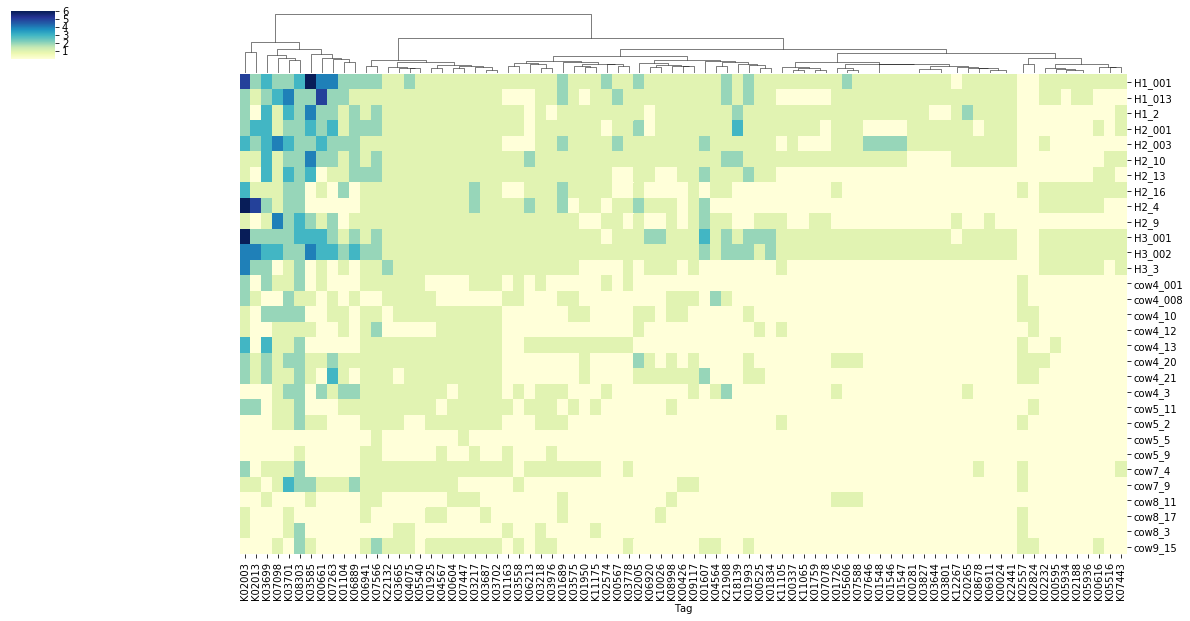

In [179]:
# Quick and dirty to check
p = sns.clustermap(df_hmap, cmap='YlGnBu', figsize=(20,10), xticklabels=True, yticklabels=True,
                   row_cluster=False, method='ward', metric='euclidean')


In [181]:
p.savefig("Cow_Hum_SD_KOs_heatmap.png")